## Часть 0: Импортирование модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
import os

from PIL import Image, ImageEnhance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from sklearn.decomposition import PCA


## Часть 1: Загрузка фотографий


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/raev_project_cv/raev_project_cv/data/images_redacted'
#all_dirs = os.listdir(path)

path = 'data/images_redacted'
all_dirs = os.listdir(path)

In [5]:
size = (128, 128) # стандарт размера для каждой картинки
pixels = 128*128
z = StandardScaler()

rgb_imgs = [] # ргб картинки
labels = []

In [6]:
for i in all_dirs:
    local_path = path + '/'+i
    for j in os.listdir(local_path):
        with Image.open(local_path + '/' + j) as im:
            img = im.resize(size = size)
        img_bright = ImageEnhance.Brightness(img).enhance(2.0)
        img_dim = ImageEnhance.Brightness(img).enhance(0.5)
        
        img_bright = np.asarray(img_bright)
        img_dim = np.asarray(img_dim)
        img = np.asarray(img)
        
        
        rgb_imgs.append(img_bright)
        rgb_imgs.append(img_dim)
        rgb_imgs.append(img)

        if i == 'SVOi':
            labels.append(1)
            labels.append(1)    #Если ориг был своим
            labels.append(1)
            
        else: 
            labels.append(-1)
            labels.append(-1)
            labels.append(-1)


for i in os.listdir('data/test'):
    with Image.open('data/test/' + i) as im:
        img = im.resize(size = size)
    img_bright = ImageEnhance.Brightness(img).enhance(2.0)
    img_dim = ImageEnhance.Brightness(img).enhance(0.5)
    
    img_bright = np.asarray(img_bright)
    img_dim = np.asarray(img_dim)
    img = np.asarray(img)
    
    
    rgb_imgs.append(img_bright)
    rgb_imgs.append(img_dim)
    rgb_imgs.append(img)
    
    if i[0] == 'f': # если файл начинается с f - то это картинка чужака
        labels.append(-1)
        labels.append(-1)
        labels.append(-1)
    else:
        labels.append(1)
        labels.append(1)
        labels.append(1)



## Часть 2: Обработка

In [7]:
gray_imgs= []
lbp_imgs = []   #Обычные
hog_imgs = []

norm_gray_imgs= []
norm_lbp_imgs = []  #Нормализованные
norm_hog_imgs = []

for i in rgb_imgs:
    gray = rgb2gray(i)
    norm_gray = z.fit_transform(gray)

    # обычные картинки
    o = hog(gray, orientations=8, pixels_per_cell=(1, 1), cells_per_block=(2, 2), feature_vector=True)
    lbp = local_binary_pattern(gray, 8, 1,'default')

    gray_imgs.append(gray)
    hog_imgs.append(o)
    lbp_imgs.append(lbp)

    # нормализованные картинки
    o = hog(norm_gray, orientations=8, pixels_per_cell=(1, 1), cells_per_block=(1, 1), feature_vector = True)
    lbp = local_binary_pattern(norm_gray, 8, 1,'default')

    norm_gray_imgs.append(norm_gray)
    norm_hog_imgs.append(o)
    norm_lbp_imgs.append(lbp)

gray_imgs = np.array(gray_imgs)
lbp_imgs  = np.array(lbp_imgs )
hog_imgs  = np.array(hog_imgs )

norm_gray_imgs = np.array(norm_gray_imgs)
norm_lbp_imgs  = np.array(norm_lbp_imgs )
norm_hog_imgs  = np.array(norm_hog_imgs )

labels = np.array(labels)

d:\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\anaconda3\Lib\site-packages\skimage\feature\te

In [8]:
def matrix_l1(X):
    return np.absolute(X).sum(axis = 1).max()

In [9]:
arr = []
idx = []
g = gray_imgs.reshape(-1, 128*128)
for i in range(-20, 21):
    try:
        n = g.shape[0]
        pca = PCA(n_components=n+i)
        pca.fit(g)
        G = pca.transform(g)
        GUt = pca.inverse_transform(G)
        arr.append(matrix_l1(GUt - g)**2 / matrix_l1(g)**2)
        idx.append(i)
        print(i)
    except:pass

-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0


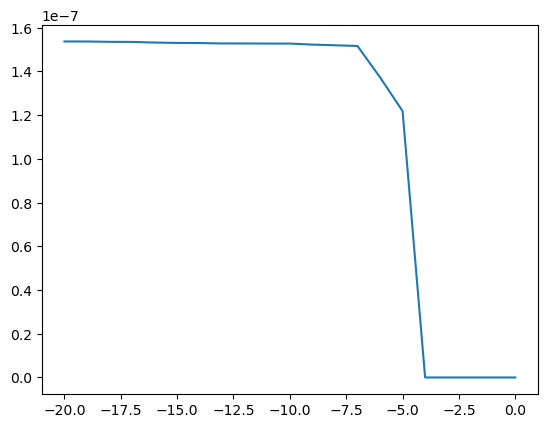

In [10]:
plt.plot(idx, arr)

In [ ]:
pca = PCA()

gray_imgs = pca.fit_transform(gray_imgs.reshape(-1, pixels))
lbp_imgs = pca.fit_transform(lbp_imgs.reshape(-1, pixels))
hog_imgs = pca.fit_transform(hog_imgs)
norm_gray_imgs = pca.fit_transform(norm_gray_imgs.reshape(-1, pixels))
norm_lbp_imgs  = pca.fit_transform(norm_lbp_imgs.reshape(-1, pixels))
norm_hog_imgs  = pca.fit_transform(norm_hog_imgs)


In [9]:
a = np.array([[1,2,34,45], [12,3,4,5]])
a.shape

(2, 4)

In [28]:
gx_train, gx_test, gy_train, gy_test = train_test_split(gray_imgs, labels, test_size= 0.4, random_state= 47) # чернобелые картинки          |
lx_train, lx_test, ly_train, ly_test = train_test_split(lbp_imgs, labels, test_size= 0.4, random_state= 47) # lbp картинки                  |<-- ненормальные данные
hx_train, hx_test, hy_train, hy_test = train_test_split(hog_imgs, labels, test_size= 0.4, random_state= 47) # hog кртнчки                   |

norm_gx_train, norm_gx_test, norm_gy_train, norm_gy_test = train_test_split(norm_gray_imgs, labels, test_size= 0.4, random_state= 47) # чернобелые картинки          |
norm_lx_train, norm_lx_test, norm_ly_train, norm_ly_test = train_test_split(norm_lbp_imgs, labels, test_size= 0.4, random_state= 47) # lbp картинки                  |<-- нормальные данные
norm_hx_train, norm_hx_test, norm_hy_train, norm_hy_test = train_test_split(norm_hog_imgs, labels, test_size= 0.4, random_state= 47) # hog кртнчки                   |

In [29]:
print('-'*8 + 'gray images'+ '-'*8)
print('train: ')
print('x -', gx_train.shape, '\n', 'y -', gy_train.shape)
print('test:')
print('x -', gx_test.shape, '\n', 'y -', gy_test.shape)

print('-'*8 + 'lbp images'+ '-'*8)
print('train: ')
print('x -', lx_train.shape, '\n', 'y -', ly_train.shape)
print('test:')
print('x -', lx_test.shape, '\n', 'y -', ly_test.shape)

print('-'*8 + 'hog images'+ '-'*8)
print('train: ')
print('x -', hx_train.shape, '\n', 'y -', hy_train.shape)
print('test:')
print('x -', hx_test.shape, '\n', 'y -', hy_test.shape)

print('-'*8 + 'normalised gray images'+ '-'*8)
print('train: ')
print('x -', norm_gx_train.shape, '\n', 'y -', norm_gy_train.shape)
print('test:')
print('x -', norm_gx_test.shape, '\n', 'y -', norm_gy_test.shape)

print('-'*8 + 'normalised lbp images'+ '-'*8)
print('train: ')
print('x -', norm_lx_train.shape, '\n', 'y -', norm_ly_train.shape)
print('test:')
print('x -', norm_lx_test.shape, '\n', 'y -', norm_ly_test.shape)

print('-'*8 + 'normalised hog images'+ '-'*8)
print('train: ')
print('x -', norm_hx_train.shape, '\n', 'y -', norm_hy_train.shape)
print('test:')
print('x -', norm_hx_test.shape, '\n', 'y -', norm_hy_test.shape)

--------gray images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)
--------lbp images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)
--------hog images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)
--------normalised gray images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)
--------normalised lbp images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)
--------normalised hog images--------
train: 
x - (307, 513) 
 y - (307,)
test:
x - (206, 513) 
 y - (206,)


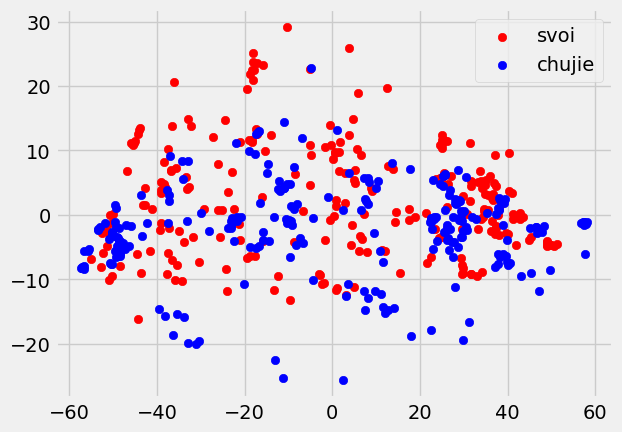

In [30]:
data_x = np.concatenate([gx_train, gx_test])
data_y = np.concatenate([gy_train, gy_test])

pca = PCA(n_components=2, random_state=47)
plot_data_x  = pca.fit_transform(data_x)
plot_data_x = np.array(plot_data_x)

df_plot = pd.DataFrame(plot_data_x, columns = ['x', 'y'])
df_plot = df_plot.assign(labels = data_y)

plus = df_plot.labels == 1
minus = df_plot.labels == -1

plt.style.use('fivethirtyeight')
plt.scatter(x = df_plot[plus].x, y = df_plot[plus].y, c ='red', label = 'svoi')
plt.scatter(x = df_plot[minus].x, y = df_plot[minus].y, c = 'blue', label = 'chujie')
plt.xticks(color = 'black')
plt.yticks(color = 'black')
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('black')

In [31]:
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-NOT_NORMALISED-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
with open('prepared_data/gx_train.pickle', 'wb') as gxtn:pickle.dump(gx_train, gxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/gx_test.pickle', 'wb') as  gxtt:pickle.dump(gx_test, gxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/gy_train.pickle', 'wb') as gytn:pickle.dump(gy_train, gytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/gy_test.pickle', 'wb') as  gytt:pickle.dump(gy_test, gytt, protocol=pickle.HIGHEST_PROTOCOL)

with open('prepared_data/lx_train.pickle', 'wb') as lxtn:pickle.dump(lx_train, lxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/lx_test.pickle', 'wb') as  lxtt:pickle.dump(lx_test, lxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/ly_train.pickle', 'wb') as lytn:pickle.dump(ly_train, lytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/ly_test.pickle', 'wb') as  lytt:pickle.dump(ly_test, lytt, protocol=pickle.HIGHEST_PROTOCOL)

with open('prepared_data/hx_train.pickle', 'wb') as hxtn:pickle.dump(hx_train, hxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/hx_test.pickle', 'wb') as  hxtt:pickle.dump(hx_test, hxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/hy_train.pickle', 'wb') as hytn:pickle.dump(hy_train, hytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/hy_test.pickle', 'wb') as  hytt:pickle.dump(hy_test, hytt, protocol=pickle.HIGHEST_PROTOCOL)

#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-NORMALISED-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
with open('prepared_data/norm_gx_train.pickle', 'wb') as ngxtn:pickle.dump(norm_gx_train, ngxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_gx_test.pickle', 'wb') as  ngxtt:pickle.dump(norm_gx_test, ngxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_gy_train.pickle', 'wb') as ngytn:pickle.dump(norm_gy_train, ngytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_gy_test.pickle', 'wb') as  ngytt:pickle.dump(norm_gy_test, ngytt, protocol=pickle.HIGHEST_PROTOCOL)

with open('prepared_data/norm_lx_train.pickle', 'wb') as nlxtn:pickle.dump(norm_lx_train, nlxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_lx_test.pickle', 'wb') as  nlxtt:pickle.dump(norm_lx_test, nlxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_ly_train.pickle', 'wb') as nlytn:pickle.dump(norm_ly_train, nlytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_ly_test.pickle', 'wb') as  nlytt:pickle.dump(norm_ly_test, nlytt, protocol=pickle.HIGHEST_PROTOCOL)

with open('prepared_data/norm_hx_train.pickle', 'wb') as nhxtn:pickle.dump(norm_hx_train, nhxtn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_hx_test.pickle', 'wb') as  nhxtt:pickle.dump(norm_hx_test, nhxtt, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_hx_train.pickle', 'wb') as nhytn:pickle.dump(norm_hy_train, nhytn, protocol=pickle.HIGHEST_PROTOCOL)
with open('prepared_data/norm_hx_test.pickle', 'wb') as  nhytt:pickle.dump(norm_hy_test, nhytt, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
knn_params ={'n_neighbors': list(range(1, 20))}

tree_params = {
    "criterion": ['gini', 'entropy'],
    "max_depth": list(range(5, 20)),
    "random_state": [47],
    'class_weight': [{1:1, -1:1.5}, {1:1, -1:2}]
}

forest_params = {
    "n_estimators": list(range(10, 400, 10)),
    "criterion": ['gini', 'entropy', 'log_loss'],
    "random_state": [47],
    'class_weight': [{1:1, -1:1.5}, {1:1, -1:2}, {1:1, -1:1}]
}

svc_params = {
    'C': np.arange(0.5, 2.1, 0.1),
    'kernel': ['rbf',],
    'gamma': ['scale', 'auto'],
    'class_weight': [{1:1, -1:1.5}, {1:1, -1:2}]
}

In [33]:
is_norm = ['norm_true', 'norm_false']
methods = ['gray', 'lbp', 'hog']
names = ['knn', 'tree', 'forest', 'svc']

data_x = {'normalised_gray':[norm_gx_train, norm_gx_test], 'normalised_lbp':[norm_lx_train, norm_lx_test], 'normalised_hog':[norm_hx_train, norm_hx_test], 'gray':[gx_train, gx_test], 'lbp':[lx_train, lx_test], 'hog':[hx_train, hx_test]}
data_y = {'normalised_gray':[norm_gy_train, norm_gy_test], 'normalised_lbp':[norm_ly_train, norm_ly_test], 'normalised_hog':[norm_hy_train, norm_hy_test], 'gray':[gy_train, gy_test], 'lbp':[ly_train, ly_test], 'hog':[hy_train, hy_test]}

models = {'knn':[KNeighborsClassifier(), knn_params],
          'tree':[DecisionTreeClassifier(), tree_params],
          'forest':[RandomForestClassifier(), forest_params],
          'svc':[SVC(), svc_params]}

results = pd.DataFrame(columns = ['model_name', 'method', 'score'])
classifiers = []

for m in models.keys():
  for i in data_x.keys():
    print(m, 'is training on', i)
    gs = GridSearchCV(estimator= models[m][0],
                        param_grid = models[m][1],
                        scoring = ['f1', 'roc_auc'],
                        cv = 5,
                        n_jobs=-1,
                        refit = 'f1'
                        )
    gs.fit(data_x[i][0], data_y[i][0])

    sc = gs.best_estimator_.score(data_x[i][1], data_y[i][1])

    results.loc[-1] = [m, i, sc]
    results = results.reset_index(drop = True)
    classifiers.append(gs.best_estimator_)




knn is training on normalised_gray
knn is training on normalised_lbp
knn is training on normalised_hog
knn is training on gray
knn is training on lbp
knn is training on hog
tree is training on normalised_gray
tree is training on normalised_lbp
tree is training on normalised_hog
tree is training on gray
tree is training on lbp
tree is training on hog
forest is training on normalised_gray
forest is training on normalised_lbp
forest is training on normalised_hog
forest is training on gray
forest is training on lbp
forest is training on hog
svc is training on normalised_gray
svc is training on normalised_lbp
svc is training on normalised_hog
svc is training on gray
svc is training on lbp
svc is training on hog


In [34]:
results.sort_values(by = 'score')

,model_name,method,score
9,tree,gray,0.737864
10,tree,lbp,0.762136
6,tree,normalised_gray,0.781553
7,tree,normalised_lbp,0.810680
11,tree,hog,0.820388
8,tree,normalised_hog,0.830097
16,forest,lbp,0.864078
12,forest,normalised_gray,0.873786
5,knn,hog,0.888350
2,knn,normalised_hog,0.888350


In [22]:
results.to_csv('crazy_results.csv')

In [19]:
classifiers[23].fit(hx_train, hy_train)

SVC(C=1.4, class_weight={-1: 1.5, 1: 1})

In [21]:
classifiers[23].score(hx_test, hy_test)

0.9902912621359223

In [24]:
svc = SVC(C = 1.4, kernel = 'rbf', class_weight={-1: 1.5, 1: 1})

In [25]:
svc.fit(hx_train, hy_train)
svc.score(hx_test, hy_test)

0.9902912621359223